In [1]:
!nvidia-smi

Tue Jun 29 16:53:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import sys
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)
sys.path.append('/content/gdrive/MyDrive')

%reload_ext tensorboard


Mounted at /content/gdrive


In [3]:
!pip install -U albumentations>=0.3.0 --user
!pip install --upgrade git+https://github.com/albumentations-team/albumentations


import albumentations as A

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-h6rudp2i
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-h6rudp2i
  Created wheel for albumentations: filename=albumentations-1.0.0-cp37-none-any.whl size=98151 sha256=40d5baa4b54e1e158bb2683a7c124ca68147d8f858d3529f32e4e48459f60a36
  Stored in directory: /tmp/pip-ephem-wheel-cache-ec6fhto3/wheels/6f/77/82/86baf8aeda64a6de0f890cd0f2fb31acaf5545cc9c99ad21ba
Successfully built albumentations
  Found existing installation: albumentations 1.0.0
    Uninstalling albumentations-1.0.0:
      Successfully uninstalled albumentations-1.0.0


In [4]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm_notebook
from tqdm import tqdm
!pip install torchsummary
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import defaultdict

# custom torch package
import torchkit
from torchkit.run import train, test, fit
from torchkit.data.dataloader import convert
from torchkit.data.dataset import CIFAR_Dataset
from torchkit.utils import data_utils, model_utils
# from torchkit.models.cifar_net import Net2
from torchkit.models.resnet import ResNet18
from torchkit.torchsummary import summary

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [5]:
# Download CIFAR data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Train and Test Transforms 

train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.ShiftScaleRotate(),
        A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16, fill_value=(0.4675, 0.4599, 0.4236), mask_fill_value = None),
        A.Normalize(mean=(0.4675, 0.4599, 0.4236), std=(0.2901, 0.2874, 0.2917)),
        ToTensorV2(),
    ])


test_transform = A.Compose(
    [
        A.Normalize(mean=(0.4675, 0.4599, 0.4236), std=(0.2901, 0.2874, 0.2917)),
        ToTensorV2(),
    ])

In [7]:
train = CIFAR_Dataset(trainset.data, trainset.targets, transforms=train_transform)
test = CIFAR_Dataset(testset.data, testset.targets, transforms=test_transform)

train_loader, test_loader = convert(train, test)


In [8]:
class GlobalConfig:
    seed = 1992
    num_classes = 10
    batch_size = 128
    EPOCHS = 10
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # data
    input_image_size = (3, 32, 32)
    trainloader = train_loader
    testloader = test_loader

    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



    # model data normalization
    channel_norm = 'BatchNorm2d'
    channel_norm_params = {'GroupNorm': {'num_groups':2},
                 'BatchNorm2d':{'affine':True},
                 'LayerNorm': {'normalized_shape':10}}
                

    # regularizer
    dropout_value = 0.05

    # loss
    # loss_function = 'CrossEntropyLoss'
    loss_function = 'NLLoss'

    # scheduler
    lr_scheduler = 'OneCycleLR'
    lr_scheduler_params = {'StepLR': {'step_size':7, 'gamma':0.5},
                
                'ReduceLROnPlateau': {'mode':'min', 'factor':0.5, 'patience':2, 'threshold':0.0001,
                                      'threshold_mode':'rel', 'cooldown':0, 'min_lr':1e-4,
                                      'eps':1e-08, 'verbose':True},
                'OneCycleLR': {'max_lr': 0.2, 'steps_per_epoch':len(trainloader), 'div_factor':20, 'epochs':EPOCHS }}
                                

    # optimizer
    optimizer = 'SGD'
    optimizer_params = {'SGD':{'lr':0.01, 'momentum':0.9}}

    # store model stats
    model_results = {'TestAccuracy': [], 
                  'TrainAccuracy': [],
                  'TestLoss': [],
                  'TrainLoss':[]}

    # Params
    misclassified=True
    L1Lambda=False

    # ModelName
    name='168K_100Epochs'

    
modelconfig = GlobalConfig


Let us show some of the training images, for fun.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

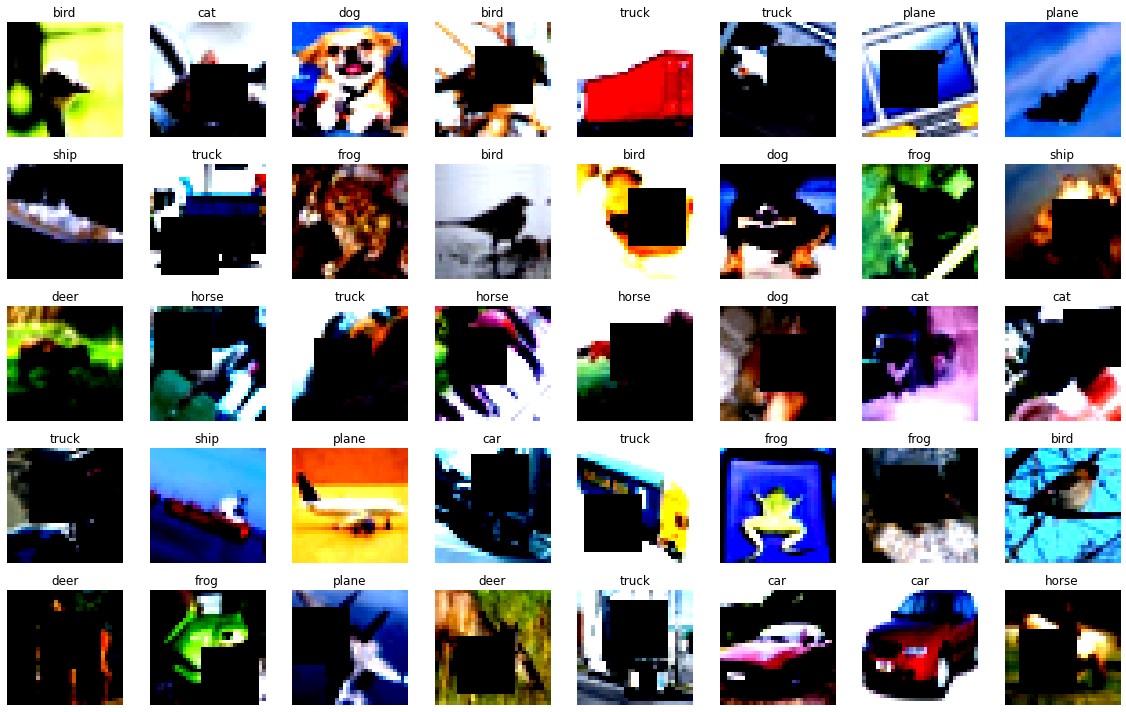

In [9]:
img, label = next(iter(modelconfig.trainloader))
data = CIFAR_Dataset(img,label)
data_utils.plot_data(data,modelconfig)

**Class/Batch Balance**

In [10]:
from collections import defaultdict
data = defaultdict()
for batch_idx, (images, labels) in enumerate(iter(modelconfig.trainloader)):
  data[batch_idx] = labels

total_data = []
first_batch = data[1]
for i in range(len(data)):
  for label in list(data[i]):
   total_data.append(label.item())

class_balance = defaultdict()
class_data = {0,1,2,3,4,5,6,7,8,9}
for i in class_data:
  class_balance[i]=total_data.count(i)
class_balance



defaultdict(None,
            {0: 5000,
             1: 5000,
             2: 5000,
             3: 5000,
             4: 5000,
             5: 5000,
             6: 5000,
             7: 5000,
             8: 5000,
             9: 5000})

All classes have same number of images, 5000. Dataset is balanced. 

In [11]:
model = ResNet18(modelconfig).to(modelconfig.device)
summary(model, (3,32,32))

------------------------------------------------------------------------------------------------
        Layer (type)               Output Shape         Param #           Receptive Field
            Conv2d-1           [-1, 64, 32, 32]           1,728               3
       BatchNorm2d-2           [-1, 64, 32, 32]             128               3
            Conv2d-3           [-1, 64, 32, 32]          36,864               5
       BatchNorm2d-4           [-1, 64, 32, 32]             128               5
            Conv2d-5           [-1, 64, 32, 32]          36,864               7
       BatchNorm2d-6           [-1, 64, 32, 32]             128               7
        BasicBlock-7           [-1, 64, 32, 32]               0               7
            Conv2d-8           [-1, 64, 32, 32]          36,864               9
       BatchNorm2d-9           [-1, 64, 32, 32]             128               9
           Conv2d-10           [-1, 64, 32, 32]          36,864              11
      BatchNo

(tensor(11173962), tensor(11173962))

In [12]:


model =  ResNet18(modelconfig).to(modelconfig.device)

result_dict, test_misc_images = run(model, modelconfig)

  0%|          | 0/391 [00:00<?, ?it/s]

==========RUNNING THE MODEL==========
EPOCH 1 | LR [0.008000000000000007]: 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
Train set: Loss=1.3203405141830444 Batch_id=390 Accuracy=41.33: 100%|██████████| 391/391 [01:00<00:00,  6.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss: 1.2251, Accuracy: 5535/10000 (55.35%)

EPOCH 2 | LR [0.05607430444909123]: 


Train set: Loss=0.9575356245040894 Batch_id=390 Accuracy=55.17: 100%|██████████| 391/391 [01:03<00:00,  6.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss: 1.0464, Accuracy: 6357/10000 (63.57%)

EPOCH 3 | LR [0.15214849387420007]: 


Train set: Loss=0.8798389434814453 Batch_id=390 Accuracy=62.71: 100%|██████████| 391/391 [01:03<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss: 0.9037, Accuracy: 6943/10000 (69.43%)

EPOCH 4 | LR [0.19999993412534253]: 


Train set: Loss=0.9598978161811829 Batch_id=390 Accuracy=66.65: 100%|██████████| 391/391 [01:04<00:00,  6.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss: 0.9403, Accuracy: 6858/10000 (68.58%)

EPOCH 5 | LR [0.19004706507083627]: 


Train set: Loss=0.6650174856185913 Batch_id=390 Accuracy=69.69: 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss: 0.6575, Accuracy: 7754/10000 (77.54%)

EPOCH 6 | LR [0.1622593496491768]: 


Train set: Loss=0.7524739503860474 Batch_id=390 Accuracy=72.14: 100%|██████████| 391/391 [01:04<00:00,  6.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss: 0.6440, Accuracy: 7842/10000 (78.42%)

EPOCH 7 | LR [0.12214048569358882]: 


Train set: Loss=0.5818046927452087 Batch_id=390 Accuracy=74.11: 100%|██████████| 391/391 [01:04<00:00,  6.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss: 0.5583, Accuracy: 8049/10000 (80.49%)

EPOCH 8 | LR [0.07763650623605368]: 


Train set: Loss=0.776838481426239 Batch_id=390 Accuracy=75.40: 100%|██████████| 391/391 [01:04<00:00,  6.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss: 0.5530, Accuracy: 8123/10000 (81.23%)

EPOCH 9 | LR [0.03756197021362588]: 


Train set: Loss=0.7192054986953735 Batch_id=390 Accuracy=76.97: 100%|██████████| 391/391 [01:04<00:00,  6.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Loss: 0.5062, Accuracy: 8289/10000 (82.89%)

EPOCH 10 | LR [0.009854130967477902]: 


Train set: Loss=0.7452636957168579 Batch_id=390 Accuracy=78.04: 100%|██████████| 391/391 [01:04<00:00,  6.08it/s]



Test set: Loss: 0.4989, Accuracy: 8303/10000 (83.03%)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

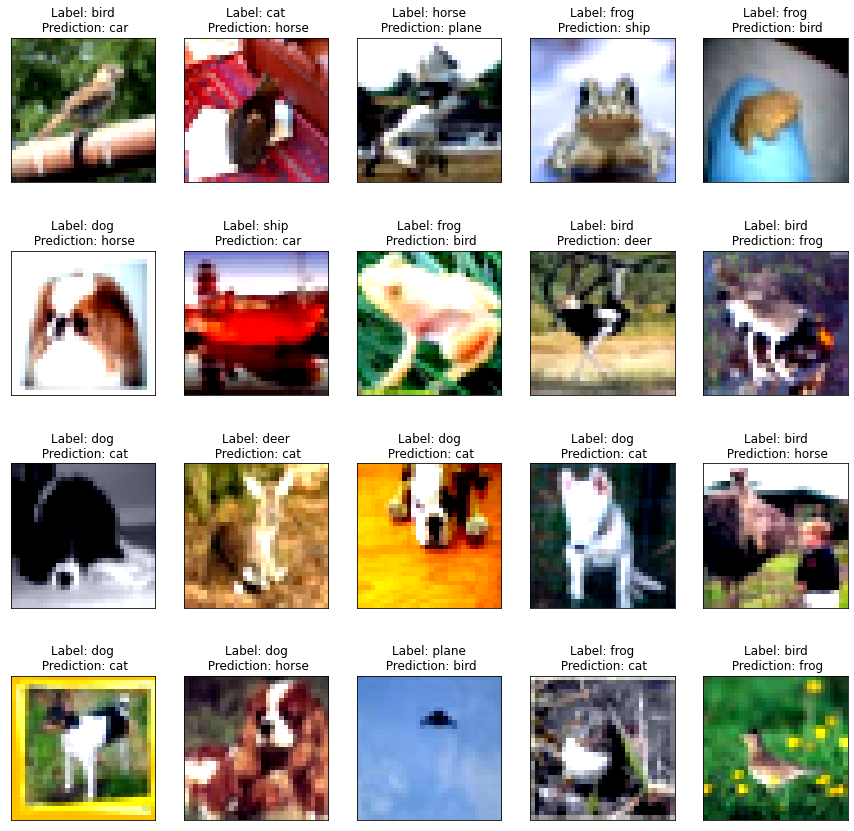

In [13]:
test_misc_images = [test_misc_images[i] for i in range(20)]
data_utils.plot_misclassified_rgb(test_misc_images, 'test_misc_batchnorm.png', config=modelconfig)

In [14]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in modelconfig.testloader:
        images, labels = data
        labels=labels.to(modelconfig.device)
        outputs = model(images.to(modelconfig.device))
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        modelconfig.classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 86 %
Accuracy of   car : 100 %
Accuracy of  bird : 72 %
Accuracy of   cat : 74 %
Accuracy of  deer : 46 %
Accuracy of   dog : 55 %
Accuracy of  frog : 85 %
Accuracy of horse : 88 %
Accuracy of  ship : 80 %
Accuracy of truck : 93 %


In [15]:
testacc = result_dict['TestAcc']
trainacc = result_dict['TrainAcc']
testloss = result_dict['TestLoss']
trainloss = result_dict['TrainLoss']
 

In [16]:
plot_details_dict = {'Test Accuracy(%)': 'Validation Accuracy',
                     'Train Accuracy(%)': 'Train Accuracy',
                     'Test Loss(%)': 'Validation Loss',
                     'Train Loss(%)': 'Train Loss'}


def plot_curve(data, y_label):
  # Plotting both the curves simultaneously
  with plt.style.context('dark_background'):# fivethirtyeight
    plt.plot(data[0:70], color='r', label='BatchNorm')
    
    # Naming the x-axis, y-axis and the whole graph
    plt.xlabel("Epochs")
    plt.ylabel(y_label)
    plt.title(plot_details_dict[y_label])
      
    # Adding legend, which helps us recognize the curve according to it's color
    plt.legend()
  

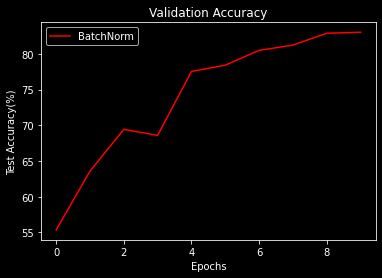

In [17]:
plot_curve(testacc, "Test Accuracy(%)")

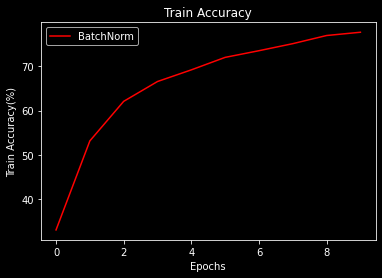

In [18]:
plot_curve(trainacc, "Train Accuracy(%)")

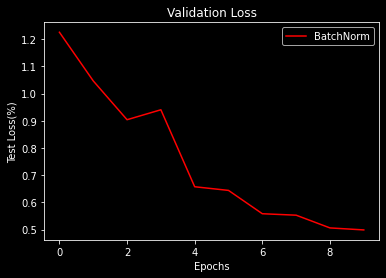

In [19]:
plot_curve(testloss, "Test Loss(%)")

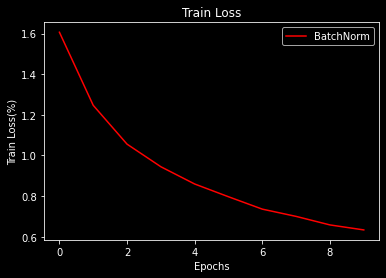

In [20]:
plot_curve(trainloss, "Train Loss(%)")